# TGFBR2
TGFBR2 codes for Transforming Growth Factor Beta Receptor 2, a transmembrane protein that has a protein kinase domain and forms a heterodimeric complex with TGF-beta receptor type-1. This complex binds TGF-beta.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1.dev0


## TGFBR2
We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier.

In [2]:
gene_symbol = 'TGFBR2'
mane_tx_id = 'NM_003242.6'
mane_protein_id = 'NP_003233.4' # TGF-beta receptor type-2 isoform B precursor

# phenopackets
We load phenopackets representing the clinical features of individuals with pathogenic variants in TGFBR2 from release 0.1.19 of phenopacket-store.

In [7]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.20'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets from cohort {gene_symbol}')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Loaded 47 phenopackets from cohort TGFBR2
Individuals Processed: 100%|██████████| 47/47 [00:01<00:00, 35.39individuals/s] 
Loaded 47 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #1
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #1
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #2
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #3
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #4
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #5
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #4
    disease

# Explorative analysis
We use functionality of GPSEA to visualize and list various aspects of the cohort.

In [8]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Aortic root aneurysm,HP:0002616,29
Joint hypermobility,HP:0001382,25
Arachnodactyly,HP:0001166,24
Scoliosis,HP:0002650,23
Arterial tortuosity,HP:0005116,20
Bifid uvula,HP:0000193,20
Epicanthus,HP:0000286,19
Malar flattening,HP:0000272,19
Disproportionate tall stature,HP:0001519,15
Dilatation of the cerebral artery,HP:0004944,14


In [9]:
from gpsea.model import ProteinMetadata
import os
if not os.path.exists("input/P37173.json"):
    raise FileNotFoundError("could not find downloaded UniProt JSON file")
protein_meta =  ProteinMetadata.from_uniprot_json(
            protein_id=mane_protein_id,
            label="transforming growth factor beta receptor 2",
            uniprot_json="input/P37173.json",
            protein_length=567,
        )

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_11679/3488743506.py:7: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


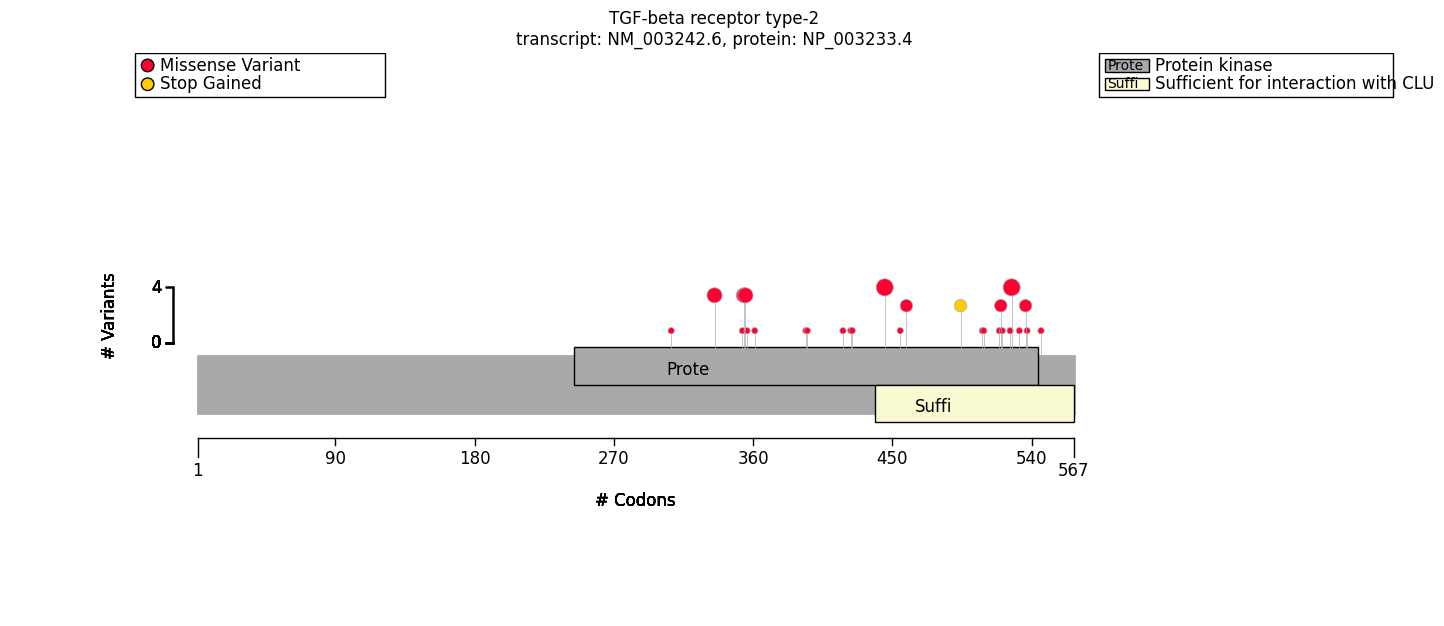

In [11]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [13]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
3_30672250_30672250_G_C,c.1067G>C,p.Arg356Pro,4,missense,3
3_30672189_30672189_T_A,c.1006T>A,p.Tyr336Asn,4,missense,3
3_30672246_30672246_G_C,c.1063G>C,p.Ala355Pro,4,missense,3
3_30691477_30691477_C_T,c.1582C>T,p.Arg528Cys,7,missense,3
3_30674186_30674186_G_A,c.1336G>A,p.Asp446Asn,5,missense,2
3_30688470_30688470_C_T,c.1483C>T,p.Arg495Ter,6,stop gained,2
3_30691504_30691504_C_T,c.1609C>T,p.Arg537Cys,7,missense,2
3_30644921_30644921_C_T,c.263+6C>T,None,None,"splice donor, intronic",2
3_30674186_30674186_G_T,c.1336G>T,p.Asp446Tyr,5,missense,2
3_30691456_30691456_T_C,c.1561T>C,p.Trp521Arg,7,missense,2


In [21]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [22]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

nterm_region = Region(start=1, end=370)
is_n_term = VariantPredicates.region(region=nterm_region, tx_id=mane_tx_id)

nterm_predicate =monoallelic_predicate(a_predicate=is_n_term,
                                    b_predicate=~is_n_term,
                                    a_label="N Term",
                                    b_label="Other")

In [23]:
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=nterm_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,36
HMF03,Skipping term because of a child term with the same individual counts,9
HMF08,Skipping general term,66
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,170


In [24]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N Term          Other  \
                                                    Count Percent  Count   
Bifid uvula [HP:0000193]                            11/12     92%   9/24   
Exotropia [HP:0000577]                                5/7     71%   1/15   
Mitral valve prolapse [HP:0001634]                    1/8     12%  11/17   
Strabismus [HP:0000486]                               5/5    100%   6/14   
Malar flattening [HP:0000272]                         8/9     89%  11/25   
Patent ductus arteriosus [HP:0001643]                6/11     55%   4/21   
Atrial septal defect [HP:0001631]                     2/9     22%   7/11   
Blue sclerae [HP:0000592]                             4/6     67%   3/14   
Disproportionate tall stature [HP:0001519]            3/9     33%  12/18   
Epicanthus [HP:0000286]                               5/5    100%  14/25   
Proptosis [HP:0000520]                                6/7     86%   5/12   
Arterial tortuosity [HP:0005116]                      7/7    100%  16/23   
Pectus carinatum [HP:0000768]                         2/4     50%   3/22   
Aortic root aneurysm [HP:0002616]                   13/13    100%  16/19   
Soft skin [HP:0000977]                                3/6     50%   4/15   
Retrognathia [HP:0000278]                            7/10     70%   5/11   
Joint hypermobility [HP:0001382]                     9/10     90%  16/22   
Scoliosis [HP:0002650]                               9/11     82%  14/21   
Pectus excavatum [HP:0000767]                         1/4     25%  11/21   
Dermal translucency [HP:0010648]                      3/6     50%   6/16   
Dilatation of the cerebral artery [HP:0004944]        3/8     38%  11/20   
Arachnodactyly [HP:0001166]                          6/11     55%  18/27   
Abnormal palate morphology [HP:0000174]             11/11    100%  20/20   
Abnormal oral cavity morphology [HP:0000163]        11/11    100%  21/21   
Abnormal axial skeleton morphology [HP:0009121]     12/12    100%  29/29   
Abnormal mandible morphology [HP:0000277]             7/7    100%  16/16   
Abnormal facial skeleton morphology [HP:0011821]      9/9    100%  18/18   
Abnormal curvature of the vertebral column [HP:...    9/9    100%  14/14   
Abnormality of the vertebral column [HP:0000925]      9/9    100%  17/17   
Long fingers [HP:0100807]                             6/6    100%  18/18   
Abnormal finger morphology [HP:0001167]               7/7    100%  21/21   
Abnormal digit morphology [HP:0011297]                7/7    100%  21/21   
Abnormal appendicular skeleton morphology [HP:0...    9/9    100%  22/22   
Slender finger [HP:0001238]                           6/6    100%  18/18   
Morphological central nervous system abnormalit...    5/5    100%  16/16   
Abnormal brain morphology [HP:0012443]                5/5    100%  14/14   
Abnormal systemic arterial morphology [HP:0011004]  13/13    100%  30/30   
Abnormal blood vessel morphology [HP:0033353]       13/13    100%  31/31   
Vascular dilatation [HP:0002617]                    13/13    100%  25/25   
Thoracic aortic aneurysm [HP:0012727]               13/13    100%  16/16   
Abnormal aortic morphology [HP:0001679]             13/13    100%  18/18   
Abnormal morphology of the great vessels [HP:00...  13/13    100%  18/18   
Abnormality of joint mobility [HP:0011729]            9/9    100%  17/17   
Talipes equinovarus [HP:0001762]                      3/6     50%   8/18   
Abnormal eyelid morphology [HP:0000492]               5/5    100%  16/16   
Vascular tortuosity [HP:0004948]                      7/7    100%  16/16   
Abnormal zygomatic bone morphology [HP:0010668]       8/8    100%  11/11   
Abnormal uvula morphology [HP:0000172]              11/11    100%    9/9   
Downslanted palpebral fissures [HP:0000494]           1/2     50%   6/18   

Allele group                                                                   \
                                          

## Protein domains
We can manually create a ProteinMetadata object with greater resolution for protein domains.
The following information was gleaned from the UniProt entry for TGFBR2.
- signal peptide: 1-22
- extracellular: 23-166 
- transmembrane domain: 167-187.
- ATP binding site: 250-258
- Protein kinase: 244-544

In [25]:
import pandas as pd
domain_list = [ {"region": "signal peptide","category": "domain", "start": 1, "end": 22, },
            {"region": "extracellular", "category": "domain", "start": 23, "end": 166, },
            {"region": "transmembrane domain", "category": "domain", "start": 167, "end": 187, },
            {"region": "ATP binding site", "category": "domain", "start": 250, "end": 258, },
             {"region": "Protein kinase", "category": "domain", "start": 244, "end": 544, },
        ]
df = pd.DataFrame(domain_list)
manual_protein_meta = ProteinMetadata.from_feature_frame(
            protein_id=mane_protein_id,
            label="TGF-beta receptor type-2",
            features=df,
            protein_length=567,
        )

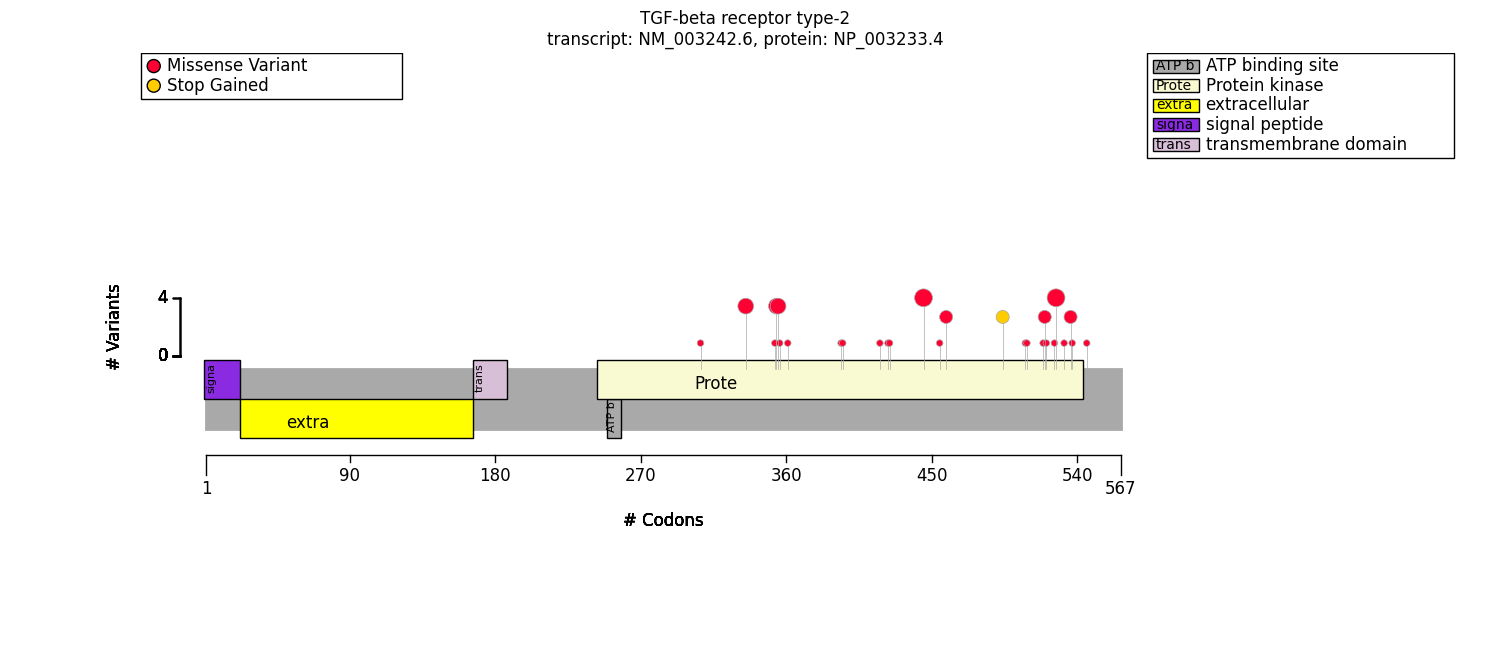

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    manual_protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [27]:
# 440–457 

f_helix = Region(start=440, end=457)
is_f_helix = VariantPredicates.region(region=f_helix, tx_id=mane_tx_id)
fhelix_predicate =monoallelic_predicate(a_predicate=is_f_helix,
                                    b_predicate=~is_f_helix,
                                    a_label="N Term",
                                    b_label="Other")

fhelix_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=fhelix_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=fhelix_result)


Allele group                                       N Term          Other  \
                                                    Count Percent  Count   
Pectus carinatum [HP:0000768]                         2/4     50%   3/22   
Arterial tortuosity [HP:0005116]                      1/2     50%  22/28   
Atrial septal defect [HP:0001631]                     1/1    100%   8/19   
Dilatation of the cerebral artery [HP:0004944]        2/2    100%  12/26   
Disproportionate tall stature [HP:0001519]            2/2    100%  13/25   
Dermal translucency [HP:0010648]                      0/2      0%   9/20   
Talipes equinovarus [HP:0001762]                      2/3     67%   9/21   
Pectus excavatum [HP:0000767]                         2/3     67%  10/22   
Epicanthus [HP:0000286]                               2/4     50%  17/26   
Arachnodactyly [HP:0001166]                           2/4     50%  22/34   
Mitral valve prolapse [HP:0001634]                    1/2     50%  11/23   
Abnormal palate morphology [HP:0000174]               3/3    100%  28/28   
Abnormal oral cavity morphology [HP:0000163]          3/3    100%  29/29   
Abnormal axial skeleton morphology [HP:0009121]       5/5    100%  36/36   
Abnormal mandible morphology [HP:0000277]             3/3    100%  20/20   
Abnormal facial skeleton morphology [HP:0011821]      3/3    100%  24/24   
Scoliosis [HP:0002650]                                2/2    100%  21/30   
Abnormal curvature of the vertebral column [HP:...    2/2    100%  21/21   
Abnormality of the vertebral column [HP:0000925]      3/3    100%  23/23   
Long fingers [HP:0100807]                             2/2    100%  22/22   
Abnormal finger morphology [HP:0001167]               3/3    100%  25/25   
Abnormal digit morphology [HP:0011297]                3/3    100%  25/25   
Abnormal appendicular skeleton morphology [HP:0...    3/3    100%  28/28   
Slender finger [HP:0001238]                           2/2    100%  22/22   
Strabismus [HP:0000486]                               1/2     50%  10/17   
Morphological central nervous system abnormalit...    3/3    100%  18/18   
Abnormal brain morphology [HP:0012443]                2/2    100%  17/17   
Abnormal systemic arterial morphology [HP:0011004]    4/4    100%  39/39   
Abnormal blood vessel morphology [HP:0033353]         4/4    100%  40/40   
Vascular dilatation [HP:0002617]                      4/4    100%  34/34   
Aortic root aneurysm [HP:0002616]                     2/2    100%  27/30   
Thoracic aortic aneurysm [HP:0012727]                 2/2    100%  27/27   
Abnormal aortic morphology [HP:0001679]               2/2    100%  29/29   
Abnormal morphology of the great vessels [HP:00...    2/2    100%  29/29   
Joint hypermobility [HP:0001382]                      3/3    100%  22/29   
Abnormality of joint mobility [HP:0011729]            3/3    100%  23/23   
Abnormal eyelid morphology [HP:0000492]               2/2    100%  19/19   
Vascular tortuosity [HP:0004948]                      1/1    100%  22/22   
Proptosis [HP:0000520]                                2/3     67%   9/16   
Malar flattening [HP:0000272]                         2/3     67%  17/31   
Abnormal zygomatic bone morphology [HP:0010668]       2/2    100%  17/17   
Bifid uvula [HP:0000193]                              2/4     50%  18/32   
Abnormal uvula morphology [HP:0000172]                2/2    100%  18/18   
Downslanted palpebral fissures [HP:0000494]           1/2     50%   6/18   

Allele group                                                                   \
                                                   Percent Corrected p values   
Pectus carinatum [HP:0000768]                          14%                1.0   
Arterial tortuosity [HP:0005116]                       79%                1.0   
Atrial septal defect [HP:0001631]                      42%                1.0   
Dilatation of the cerebral artery [HP:0004944]         46%                1.0   
Disproportionate 